#### If you haven't installed Hummingbird, do that first, by uncommenting the line below.


In [1]:
#! pip install hummingbird_ml 

#### Import Hummingbird's convert function

In [2]:
from hummingbird.ml import convert

#### Download and unzip the Year data

In [3]:
import zipfile
import urllib.request as urllib
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip'

filehandle, _ = urllib.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
filename = zip_file_object.namelist()[0]
bytes_data = zip_file_object.open(filename).read()

#### Convert the bytes to pandas and split it up

In [4]:
import pandas as pd
from io import BytesIO
from sklearn.model_selection import train_test_split

year = pd.read_csv(BytesIO(bytes_data), header = None)

X = year.iloc[:, 1:]
y = year.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=463715, test_size=51630)

# Store the test data as numpy by pulling the values out of the pandas dataframe
data = X_test.values

In [5]:
# peak at the data if desired
X_test.head()

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
463715,45.44200,-30.74976,31.78587,4.63569,-15.14894,0.23370,-11.97968,-9.59708,6.48111,-8.89073,...,-8.84046,-0.15439,137.44210,77.54739,-4.22875,-61.92657,-33.52722,-3.86253,36.42400,7.17309
463716,52.67814,-2.88914,43.95268,-1.39209,-14.93379,-15.86877,1.19379,0.31401,-4.44235,-5.78934,...,-5.74356,-42.57910,-2.91103,48.72805,-3.08183,-9.38888,-7.27179,-4.00966,-68.96211,-5.21525
463717,45.74235,12.02291,11.03009,-11.60763,11.80054,-11.12389,-5.39058,-1.11981,-7.74086,-3.33421,...,-4.70606,-24.22599,-35.22686,27.77729,15.38934,58.20036,-61.12698,-10.92522,26.75348,-5.78743
463718,52.55883,2.87222,27.38848,-5.76235,-15.35766,-15.01592,-5.86893,-0.31447,-5.06922,-4.62734,...,-8.35215,-16.86791,-10.58277,40.10173,-0.54005,-11.54746,-45.35860,-4.55694,-43.17368,-3.33725
463719,51.34809,9.02702,25.33757,-6.62537,0.03367,-12.69565,-3.13400,2.98649,-6.71750,-1.85804,...,-6.87366,-20.03371,-66.38940,50.56569,0.27747,67.05657,-55.58846,-7.50859,28.23511,-0.72045


#### Train the model  (Note, this may take a bit of time. )

In [6]:
import lightgbm as lgb

lgbm_model = lgb.LGBMRegressor(max_depth=8,n_estimators=500, num_leaves=256, objective="regression", reg_lambda=1, n_jobs=6)

lgbm_model.fit(X_train, y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=6, num_leaves=256,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=1, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

#### LGBM (CPU only)

In [7]:
lgbm_time = %timeit -o lgbm_model.predict(data)

844 ms ± 6.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Convert LGBM model to PyTorch

In [8]:
model = convert(lgbm_model, 'torch')

Finished loading model, total used 500 iterations


#### Time PyTorch - CPU

In [9]:
pred_cpu_hb = %timeit -o model.predict(data)

1.78 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
X_test.values.shape

(51630, 90)

#### Switch PyTorch from CPU to GPU

In [11]:
%%capture 
model.to('cuda')

#### Time PyTorch - GPU

In [12]:
pred_gpu_hb = %timeit -o model.predict(data)

50 ms ± 243 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Note: Continuing in this notebook requires TVM built with LLVM support. Install instructions [here](https://tvm.apache.org/docs/install/index.html)

#### Convert LGBM model to TVM (CPU)

In [13]:
model_tvm = convert(lgbm_model, 'tvm', data)

Finished loading model, total used 500 iterations


#### Time TVM - CPU

In [14]:
pred_cpu_tvm = %timeit -o model_tvm.predict(data)

803 ms ± 8.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Convert LBGM model to TVM (GPU)

In [15]:
model_tvm = convert(lgbm_model, 'tvm', data, 'cuda')

Finished loading model, total used 500 iterations


#### Time TVM - GPU

In [16]:
pred_gpu_tvm = %timeit -o model_tvm.predict(data)

31.1 ms ± 402 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Plot the results

In [17]:
def plot(title, lgbm_time, pred_cpu_hb, pred_gpu_hb, pred_cpu_tvm, pred_gpu_tvm):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.pyplot import cm

    fig = plt.figure()

    x = ['lgbm','pyt-cpu','pyt-gpu','tvm-cpu','tvm-gpu']
    height = [lgbm_time.average,pred_cpu_hb.average,pred_gpu_hb.average,pred_cpu_tvm.average,pred_gpu_tvm.average]
    width = 1.0
    plt.ylabel('time in seconds')
    plt.xlabel(title)

    rects = plt.bar(x, height, width, color=cm.rainbow(np.linspace(0,1,5)))
    def autolabel(rects):

        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%.4f' % (height),
                    ha='center', va='bottom')

    autolabel(rects)
    plt.show()

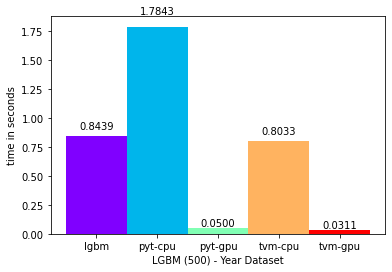

In [18]:
plot("LGBM (500) - Year Dataset", lgbm_time, pred_cpu_hb, pred_gpu_hb, pred_cpu_tvm, pred_gpu_tvm)